In [2]:
import arviz as az

try:
    import bambi as bmb
except ModuleNotFoundError:
    %pip install bambi
    import bambi as bmb
import jax
import jax.numpy as jnp
import logging
import matplotlib.pyplot as plt
import pandas as pd
import pymc3 as pm
import seaborn as sns
import tensorflow_probability.substrates.jax as tfp

from rmh import rmh_inference_loop,plot_rmh

tfd = tfp.distributions

logger = logging.getLogger()
class CheckTypesFilter(logging.Filter):
    def filter(self, record):
        return "check_types" not in record.getMessage()
logger.addFilter(CheckTypesFilter())

In [4]:
az.style.use("arviz-darkgrid")
key = jax.random.PRNGKey(1)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


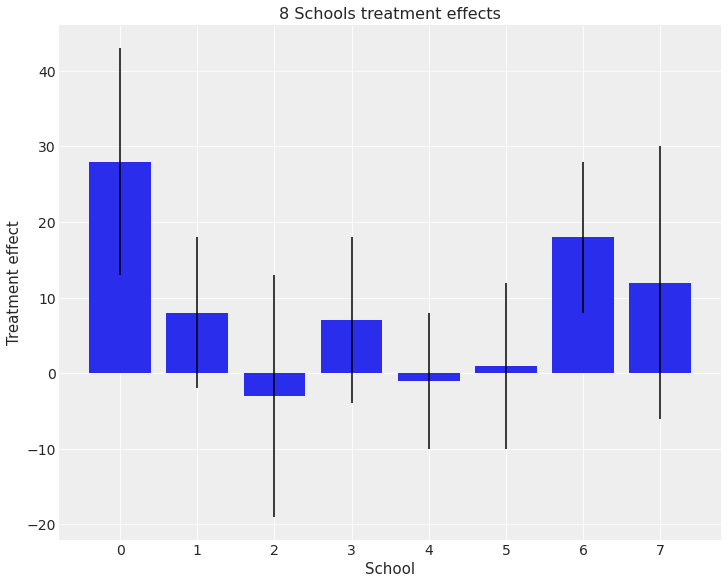

In [6]:
num_schools = 8  # number of schools
treatment_effects = jnp.array(
    [28, 8, -3, 7, -1, 1, 18, 12], dtype=jnp.float32)  # treatment effects
treatment_stddevs = jnp.array(
    [15, 10, 16, 11, 9, 11, 10, 18], dtype=jnp.float32)  # treatment SE

fig, ax = plt.subplots()
plt.bar(range(num_schools), treatment_effects, yerr=treatment_stddevs)
plt.title("8 Schools treatment effects")
plt.xlabel("School")
plt.ylabel("Treatment effect")
fig.set_size_inches(10, 8)
plt.show()


# Multilevel Model
\begin{align*}
y_i = \text{treatment effects} \\
\sigma_i= \text{std dev treatement effects.} 
\end{align*}

These two are the observed variables. 

![8 schools](8_schools_model.png)

In [49]:
prior_mu = tfd.Normal(0,10)
prior_tou = tfd.LogNormal(5,1)


def log_post_fn(params):
    mu,tou,theta = params['mu'],params['tou'],params['theta']
    log_prior_mu = prior_mu.log_prob(mu)
    log_prior_tou = prior_tou.log_prob(tou)
    log_prior_theta = jnp.sum(tfd.Normal(mu,tou).log_prob(theta))
    log_like = 0
    for i in range(treatment_effects.shape[0]):
        log_like += tfd.Normal(theta[i],treatment_stddevs[i]).log_prob(treatment_effects[i])
    return log_like+log_prior_mu+log_prior_theta+log_prior_tou

params = {
    'mu' : 10.0,
    'tou': 15.0,
    'theta': jnp.ones(treatment_effects.shape[0])*8

}
log_post_fn(params)

DeviceArray(-68.73927, dtype=float32)

In [50]:
states = rmh_inference_loop(log_post_fn,jnp.ones(10)*2,params,10000)

In [51]:
keys_states = states.position.keys()
values_states = states.position.values()

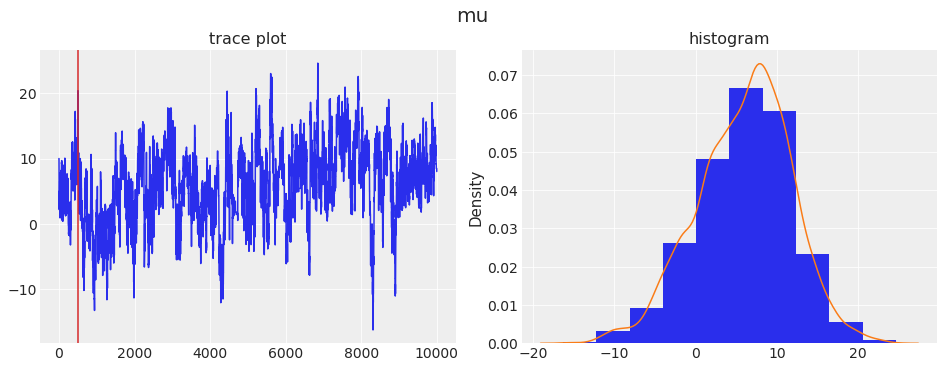

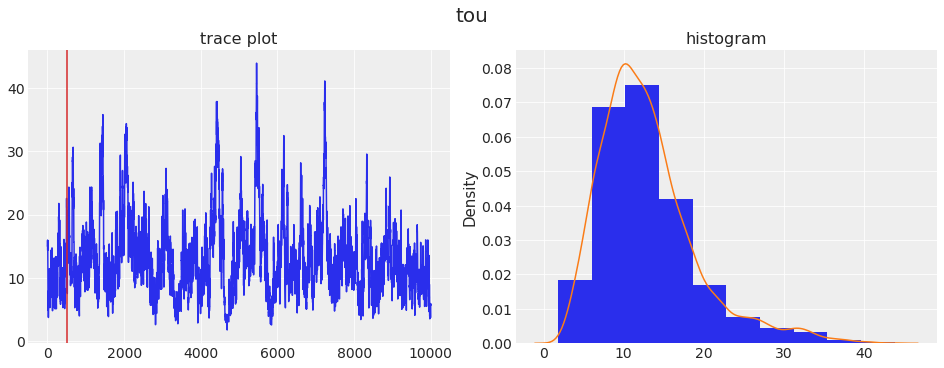

In [52]:
thetas = states.position['theta']
del states.position['theta']

plot_rmh(states,500)

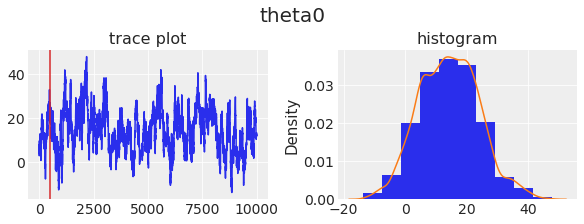

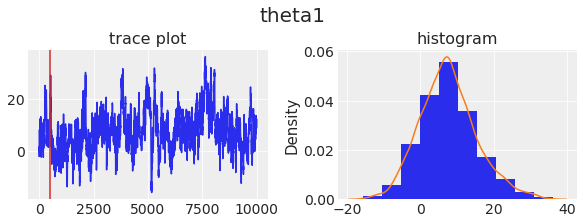

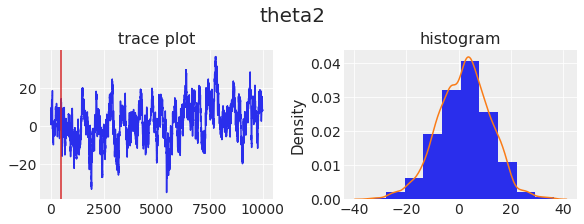

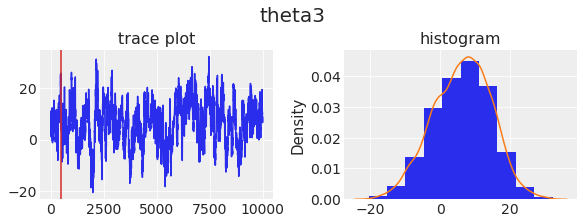

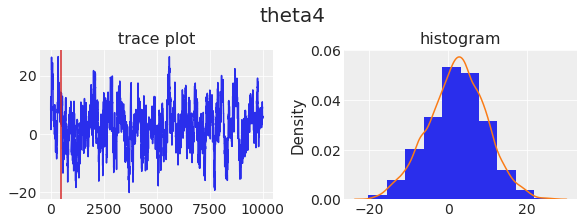

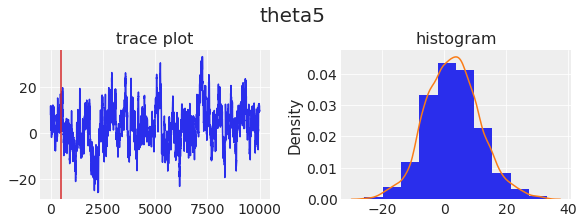

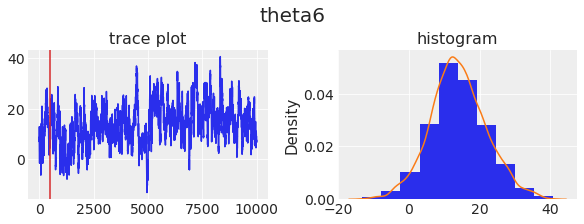

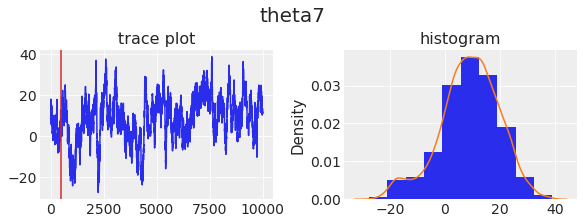

In [53]:
states.position['theta'] = thetas
for key_state in list(keys_states):
    if(key_state!='theta'):
        del states.position[key_state]

plot_rmh(states,500,contains_arrays=True)


In [54]:
treatment_effects.mean()

DeviceArray(8.75, dtype=float32)

In [55]:
treatment_effects

DeviceArray([28.,  8., -3.,  7., -1.,  1., 18., 12.], dtype=float32)

In [56]:
jnp.mean(thetas[5000:,:],axis=0)

DeviceArray([14.231017 ,  8.812172 ,  4.936545 ,  6.985758 ,  2.9108534,
              4.398789 , 17.00747  , 12.474563 ], dtype=float32)

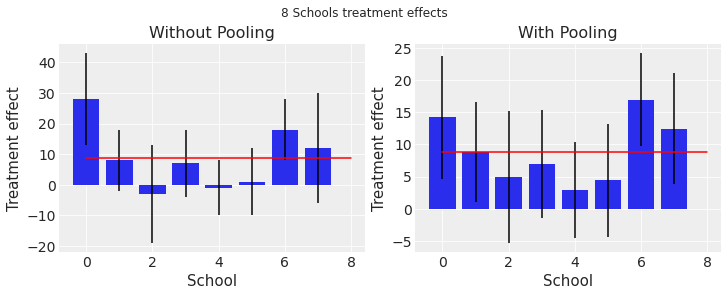

In [71]:
fig, (ax1,ax2)= plt.subplots(1,2,figsize=(10,4))
ax1.bar(range(num_schools), treatment_effects, yerr=treatment_stddevs)
ax2.bar(range(num_schools), jnp.mean(thetas[5000:,:],axis=0), yerr=jnp.std(thetas[5000:,:],axis=0))
ax1.plot([0,8],[treatment_effects.mean(),treatment_effects.mean()],color='r',label='global mean')
ax2.plot([0,8],[treatment_effects.mean(),treatment_effects.mean()],color='r',label='global mean')
ax1.set_xlabel("School")
ax1.set_ylabel("Treatment effect")
ax1.set_title("Without Pooling")
ax2.set_title("With Pooling")
plt.suptitle("8 Schools treatment effects")
plt.xlabel("School")
plt.ylabel("Treatment effect")
plt.show()
